<a href="https://colab.research.google.com/github/brandonweber2022/INST-354-Final-Project/blob/main/Sprint_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("nba_2022-23_all_stats_with_salary.csv")

print("Shape:", df.shape)
df.info()
df.head()

Shape: (467, 52)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     467 non-null    int64  
 1   Player Name    467 non-null    object 
 2   Salary         467 non-null    int64  
 3   Position       467 non-null    object 
 4   Age            467 non-null    int64  
 5   Team           467 non-null    object 
 6   GP             467 non-null    int64  
 7   GS             467 non-null    int64  
 8   MP             467 non-null    float64
 9   FG             467 non-null    float64
 10  FGA            467 non-null    float64
 11  FG%            466 non-null    float64
 12  3P             467 non-null    float64
 13  3PA            467 non-null    float64
 14  3P%            454 non-null    float64
 15  2P             467 non-null    float64
 16  2PA            467 non-null    float64
 17  2P%            463 non-null    float6

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


FT%     23
3P%     13
2P%      4
eFG%     1
3PAr     1
FTr      1
TS%      1
FG%      1
dtype: int64


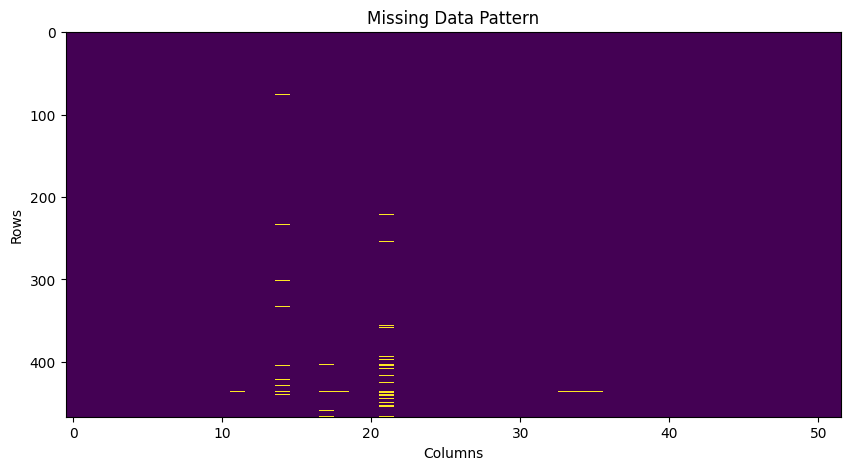

In [ ]:
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

plt.figure(figsize=(10,5))
plt.imshow(df.isnull(), aspect="auto", interpolation="nearest")
plt.title("Missing Data Pattern")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [ ]:
for col in ["Unnamed: 0", "index"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Standardize multi-team labels
df["Team"] = df["Team"].astype(str).str.split("/").str[0].str.strip()

# Add salary in millions
df["Salary_M"] = df["Salary"] / 1_000_000

# Keep NaNs in shooting % columns
shoot_cols = ["FT%", "3P%", "2P%", "TS%", "3PAr", "FTr", "eFG%", "FG%"]
df_filled = df.copy()
df_filled[shoot_cols] = df_filled[shoot_cols].fillna(0)

# Check duplicates
dup_players = df["Player Name"].duplicated().sum()
print("Duplicate player names:", dup_players)

Duplicate player names: 0


In [ ]:
df["Salary_per_WS"] = df["Salary"] / df["WS"].replace(0, np.nan)
df["PTS_per_Million"] = df["PTS"] / df["Salary_M"].replace(0, np.nan)
df["log_Salary"] = np.log1p(df["Salary"])

df.head(3)

,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,...,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary_M,Salary_per_WS,PTS_per_Million,log_Salary
0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,...,7.8,0.192,7.5,0.1,7.5,4.7,48.070014,6.162822e+06,0.611608,17.688169
1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,...,0.3,0.020,-0.8,-0.4,-1.2,0.1,47.345760,1.578192e+08,0.240782,17.672988
2,Russell Westbrook,47080179,PG,34,LAL,73,24,29.1,5.9,13.6,...,1.9,0.044,0.3,-0.1,0.2,1.2,47.080179,2.477904e+07,0.337722,17.667363


            count       mean        std        min        25%        50%  \
Salary_M    467.0   8.416599  10.708118   0.005849   1.782621   3.722040   
PTS         467.0   9.129979   6.906006   0.000000   4.100000   7.100000   
PER         467.0  13.279657   6.230049 -20.900000  10.100000  13.000000   
WS          467.0   2.328908   2.533094  -1.600000   0.300000   1.500000   
BPM         467.0  -1.432548   4.925175 -26.500000  -3.300000  -1.300000   
Age         467.0  25.820128   4.275113  19.000000  23.000000  25.000000   
log_Salary  467.0  15.072544   1.545650   8.674197  14.393596  15.129783   

                  75%        max  
Salary_M    10.633544  48.070014  
PTS         11.700000  33.100000  
PER         16.350000  65.600000  
WS           3.550000  12.600000  
BPM          0.600000  48.600000  
Age         29.000000  42.000000  
log_Salary  16.179495  17.688169  


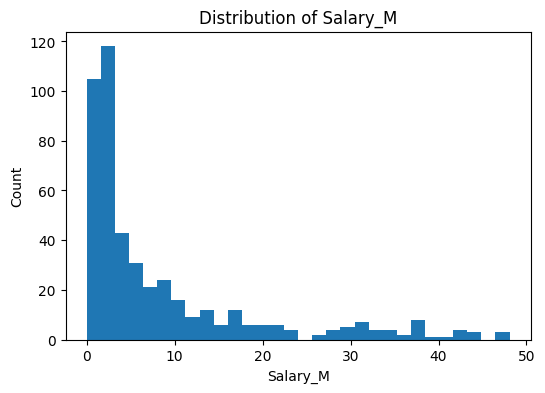

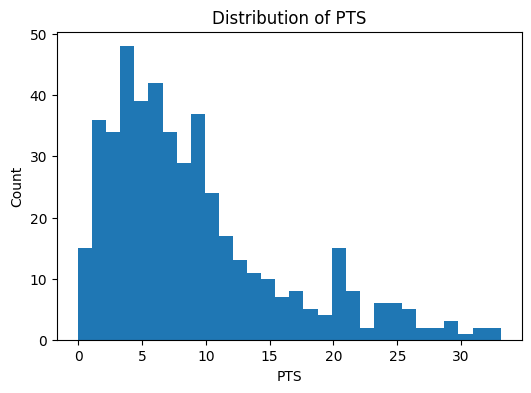

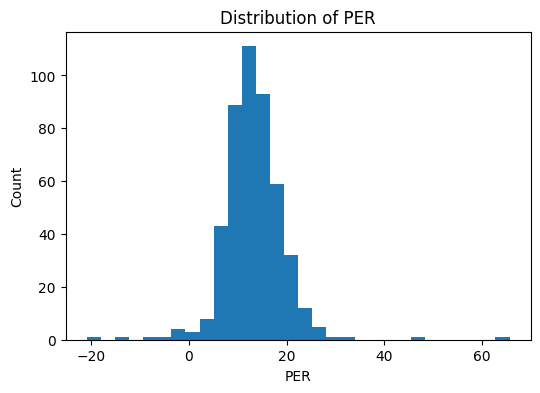

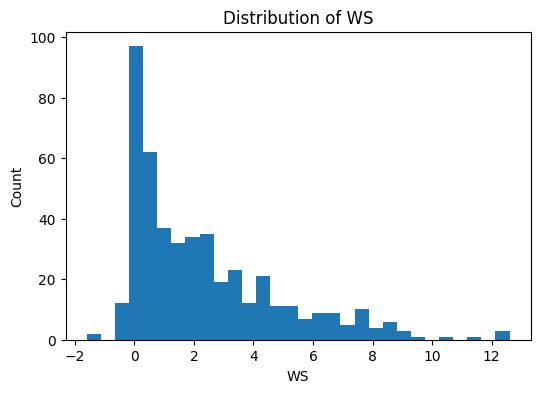

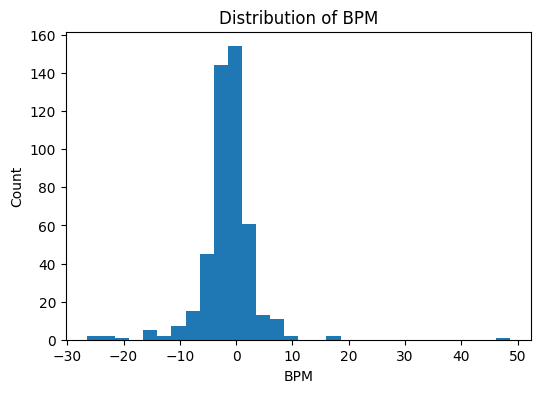

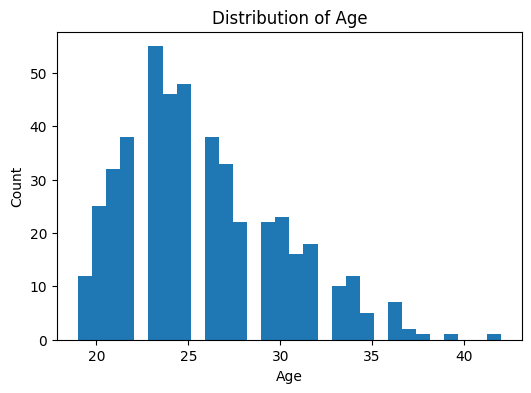

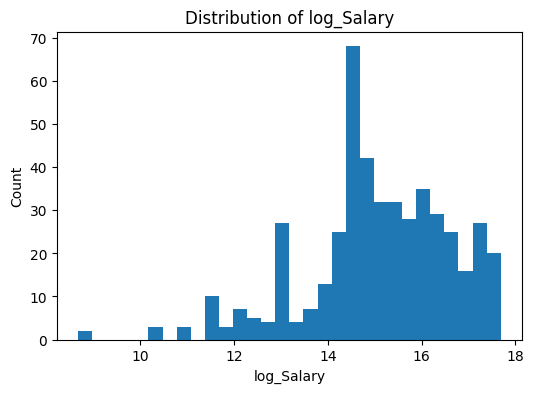

In [ ]:
univariate_vars = ["Salary_M", "PTS", "PER", "WS", "BPM", "Age", "log_Salary"]
print(df[univariate_vars].describe().T)

for col in univariate_vars:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

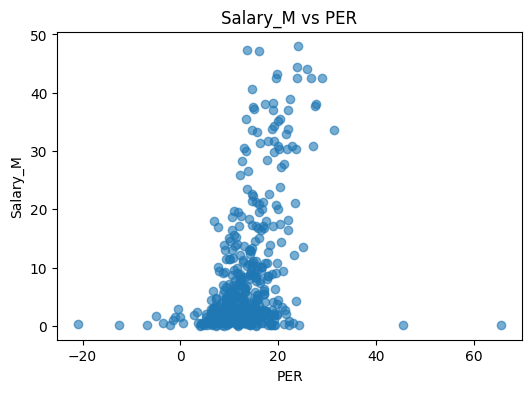

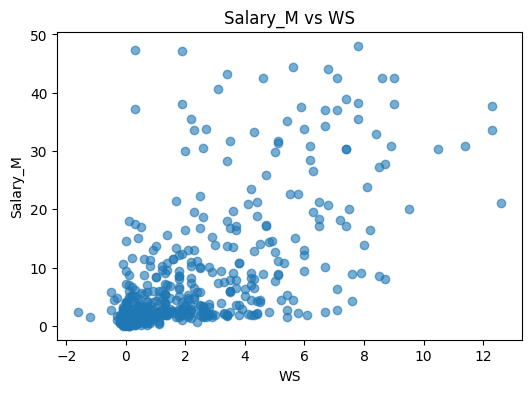

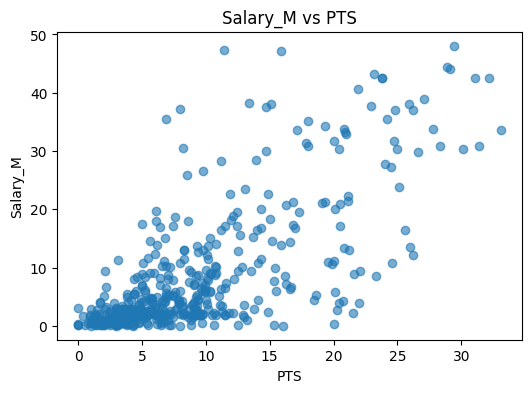

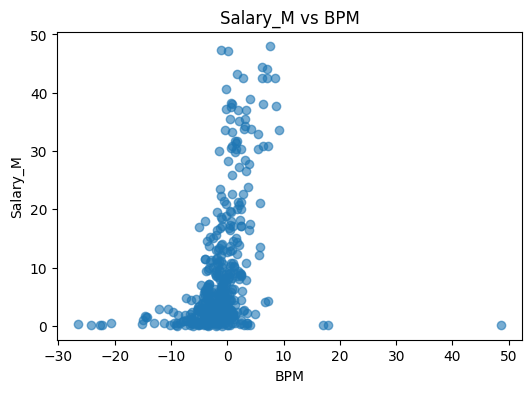

In [ ]:
pairs = [("PER", "Salary_M"), ("WS", "Salary_M"), ("PTS", "Salary_M"), ("BPM", "Salary_M")]

for x, y in pairs:
    plt.figure(figsize=(6,4))
    plt.scatter(df[x], df[y], alpha=0.6)
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

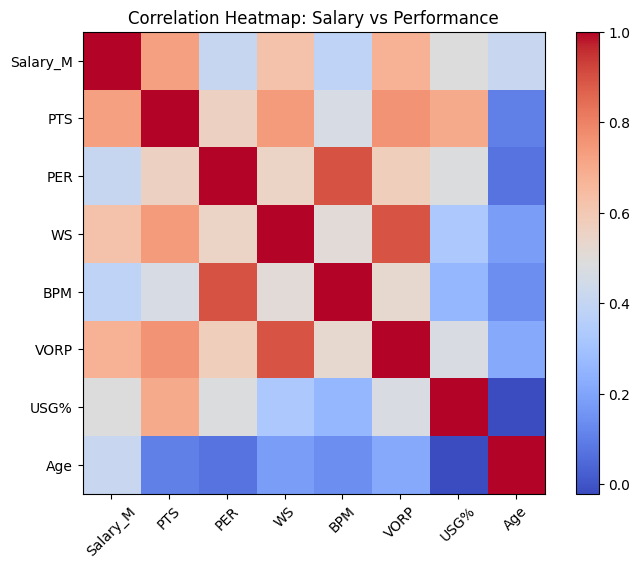

,Salary_M,PTS,PER,WS,BPM,VORP,USG%,Age
Salary_M,1.000000,0.727597,0.411790,0.624664,0.382346,0.680339,0.488063,0.416072
PTS,0.727597,1.000000,0.557184,0.737074,0.463668,0.756909,0.698293,0.102828
PER,0.411790,0.557184,1.000000,0.551584,0.899004,0.575725,0.483547,0.073592
WS,0.624664,0.737074,0.551584,1.000000,0.508964,0.892780,0.326903,0.179082
BPM,0.382346,0.463668,0.899004,0.508964,1.000000,0.527825,0.260791,0.141171
VORP,0.680339,0.756909,0.575725,0.892780,0.527825,1.000000,0.472613,0.215787
USG%,0.488063,0.698293,0.483547,0.326903,0.260791,0.472613,1.000000,-0.021458
Age,0.416072,0.102828,0.073592,0.179082,0.141171,0.215787,-0.021458,1.000000


In [ ]:
corr_vars = ["Salary_M", "PTS", "PER", "WS", "BPM", "VORP", "USG%", "Age"]
corr = df[corr_vars].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.xticks(range(len(corr_vars)), corr_vars, rotation=45)
plt.yticks(range(len(corr_vars)), corr_vars)
plt.title("Correlation Heatmap: Salary vs Performance")
plt.colorbar()
plt.show()

corr

In [ ]:
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    print(f"{column}: {len(outliers)} outliers detected")
    return outliers, lower, upper

outliers_salary, low_s, high_s = find_outliers_iqr(df, "Salary_M")
outliers_per, _, _ = find_outliers_iqr(df, "PER")
outliers_ws, _, _ = find_outliers_iqr(df, "WS")

# Preview salary outliers (likely superstars)
outliers_salary[["Player Name", "Team", "Salary_M", "PTS", "PER", "WS"]].head(10)

Salary_M: 48 outliers detected
PER: 20 outliers detected
WS: 14 outliers detected


,Player Name,Team,Salary_M,PTS,PER,WS
0,Stephen Curry,GSW,48.070014,29.4,24.1,7.8
1,John Wall,LAC,47.345760,11.4,13.6,0.3
2,Russell Westbrook,LAL,47.080179,15.9,16.1,1.9
3,LeBron James,LAL,44.474988,28.9,23.9,5.6
4,Kevin Durant,BRK,44.119845,29.1,25.9,6.8
5,Bradley Beal,WAS,43.279250,23.2,19.7,3.4
6,Kawhi Leonard,LAC,42.492492,23.8,23.9,7.1
7,Paul George,LAC,42.492492,23.8,19.6,4.6
8,Giannis Antetokounmpo,MIL,42.492492,31.1,29.0,8.6
9,Damian Lillard,POR,42.492492,32.2,26.7,9.0


          count       mean        std        min        25%        50%  \
Position                                                                 
C          91.0   7.282722   8.983558   0.116986   1.930681   2.905851   
PF         86.0   8.885045  10.897789   0.005849   1.878720   4.358959   
PG         77.0  11.579573  13.889342   0.005849   1.563518   4.833600   
PG-SG       2.0  21.458528  24.690088   4.000000  12.729264  21.458528   
SF         91.0   8.132253  11.055604   0.035096   1.673633   3.536160   
SF-PF       1.0   3.000000        NaN   3.000000   3.000000   3.000000   
SF-SG       2.0  12.239763  11.116054   4.379526   8.309645  12.239763   
SG        115.0   6.681301   8.308597   0.032171   1.563518   2.925600   
SG-PG       2.0  16.650807   4.029367  13.801614  15.226211  16.650807   

                75%        max  
Position                        
C          9.394609  38.172414  
PF        11.994549  44.474988  
PG        17.207142  48.070014  
PG-SG     30.187793 

/tmp/ipython-input-3987871348.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_pos, labels=pos_summary.index)


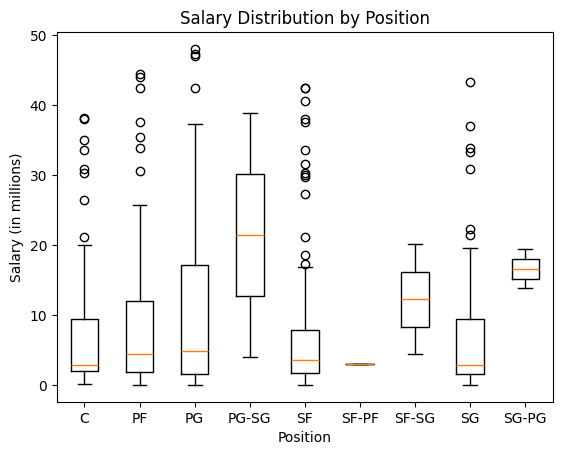

In [ ]:
pos_summary = df.groupby("Position")["Salary_M"].describe()
print(pos_summary)

data_by_pos = [df.loc[df["Position"]==p, "Salary_M"].dropna() for p in pos_summary.index]
plt.boxplot(data_by_pos, labels=pos_summary.index)
plt.title("Salary Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Salary (in millions)")
plt.show()

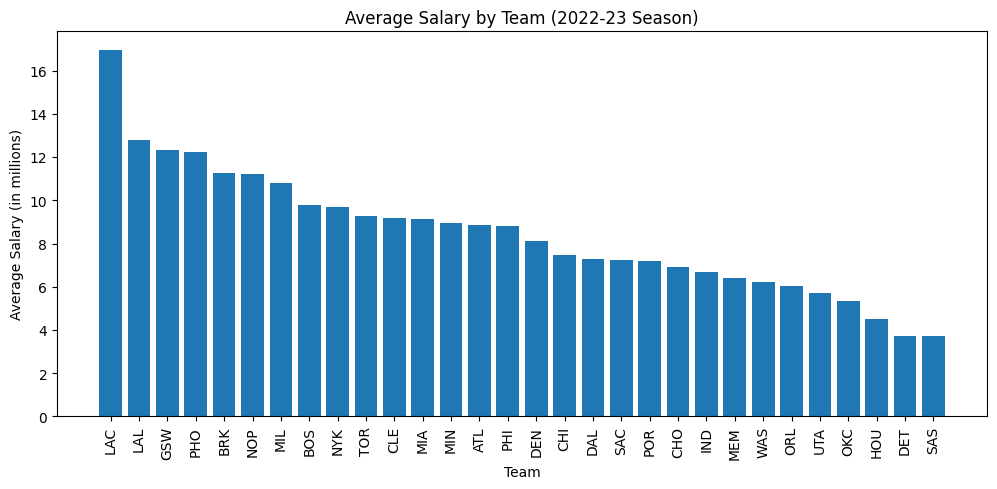

In [ ]:
team_salary = df.groupby("Team")["Salary_M"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,5))
plt.bar(team_salary.index, team_salary.values)
plt.xticks(rotation=90)
plt.title("Average Salary by Team (2022-23 Season)")
plt.xlabel("Team")
plt.ylabel("Average Salary (in millions)")
plt.show()